In [1]:
import numpy as np
import pandas as pd
import glob

In [567]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy.sparse import random
import librosa
import matplotlib.pyplot as plt
from scipy.spatial import distance
from numpy.random import default_rng
import soundfile as sf
import os
from numpy.linalg import norm

## Create data

### Create white noise data

In [846]:
def make_noises(mu=0, sigma=1, n=10, t_size=10000):
    rng = np.random.default_rng()
    noises = rng.normal(mu, sigma, (n,t_size))
#     for i in range(n):
# #         mu = float(rng.normal(0, 1, 1))
# #         sigma = abs(float(rng.normal(0, 2, 1)))
#         noise = rng.normal(mu, sigma, t_size)
#         if noises.size > 0:
#             noises = np.vstack((noises,noise))
#         else:
#             noises = noise.copy()
    return(noises)

### Create MFCCs

In [569]:
def make_mfcc(folder):
    """
    Go through the folder and find all (and only) files ending with .wav
    Here, we transform each .wav file into MFCCs and then flatten them into one vector.
    We do this because we want one hash per .wav file.
    
    Any file shorter than the longest file in the folder will be padded with values 0,
    so that all concatenated file vectors are of the same length.
    
    Parameters
    ----------
    folder : path to folder with wav sounds
    
    Returns
    -------
    a list of flattened MFCC vectors
    """
    vectors = []
    for file in [x for x in os.listdir(folder) if x.endswith(".wav")]:
        filename = os.path.join(folder, file)
        y, sr = librosa.load(filename)
        mfcc_feat = librosa.feature.mfcc(y=y, sr=sr)
        vect = mfcc_feat.flatten()
        vectors.append(vect)
        print(len(vectors), " mfccs done")
    # find the largest vector
    max_length = len(max(vectors, key=lambda p: len(p)))
    # append zeros to all the other vectors
    for i in range(len(vectors)):
        vectors[i] = np.pad(vectors[i], (0,max_length-len(vectors[i])))
    return vectors

## Create hashed data

### Fly olfactory algorithm hashing from [1]

In [570]:
# def make_binary_lsh(X, m, seed=82):
#     """
#     Hash the data with binary locality sensitive-hashing algorithm from Supplementary materials of [1].
    
#     h : R^d --> Z^m, d<<m
#     y = sgn(Mx)
    
#     M : dense i.i.d. Gaussian random matrix
#     x : input
    
#     Parameters
#     ----------
#     X : np array
#         input vectors
#     m : int
#         dimension of the output
    
#     Returns
#     -------
#     h : np array
#         hashed output y of dimension m
#     """
    
#     d = X.shape[1]
#     rng = default_rng(seed)
#     M = rng.standard_normal((m,d))
#     h = []
#     y = np.inner(M,X)
#     y = np.sign(y)
#     y[y<=0] = 0
#     h = np.transpose(y)
# #     for x in X:
# #         y = np.inner(M,x)
# #         y = np.sign(y)
# #         y[y<=0] = 0
# #         h.append(np.transpose(y))
    
# #     return(np.array(h))
#     return(h)

In [571]:
# def make_binary_fly_hash(X, m, k, seed = 30):
#     """
#     Hash the data with binary fly WTA hashing algorithm [1] - Supplementary material.
    
#     h : R^d --> Z^m, d<<m
    
#     M is a sparse m x d matrix, 1 if input connects to output, 0 otherwise.
#     y = Mx, where values are 1 if y_i is one of the k largest values in y, 0 otherwise.
    
#     Parameters
#     ----------
#     X : np array
#         input vectors
#     m : int
#         dimension of the output
#     k : int
#         number of active values in an array
#     seed : int
#         seed for randomization
    
#     Returns
#     -------
#     h : np array
#         hashed output y of dimension m
#     """
    
#     rng = default_rng(seed)
#     d = X.shape[1]
#     p = 6/d
#     M = np.zeros((m,d))
# #     M[np.random.rand(*M.shape) < p] = 1
#     M[rng.random(M.shape) < p] = 1
#     y = np.inner(M,X)
#     h = np.transpose(y)
#     top_z = np.argsort(h) # sort by size, get from smallest to largest indices
#     top_k = top_z[:,-k:] # top k elements
#     bottom_k = top_z[:,:-k]
#     for i in range(h.shape[0]):
#         h[i][top_k[i]] = 1
#         h[i][bottom_k[i]] = 0
#     return(h)

In [601]:
def apply_hash(X, M, k):
    # define hash
    assert X.shape[1] == M.shape[1]
    
    y = np.inner(M,X)
    h = np.transpose(y)
    top_z = np.argsort(h) # sort by size, get from smallest to largest indices
    top_k = top_z[:,-k:] # top k elements
    bottom_k = top_z[:,:-k]
    for i in range(h.shape[0]):
        h[i][top_k[i]] = 1
        h[i][bottom_k[i]] = 0
        
    return(h)
    
def generate_hash_matrix(d, m, seed = 30):
    # define M
    rng = default_rng(seed)
    p = 6/d
    M = np.zeros((m,d))
    M[rng.random(M.shape) < p] = 1
    
    return(M)


p = 0.1
d = 10000
N = 100
k = int(N*p)
X = make_noises(n=10, t_size=d)
M = generate_hash_matrix(d, N)
h = apply_hash(X, M, k)

In [572]:
# test hashing
z = np.array([np.arange(10)])
make_binary_fly_hash(z, 10, 3, seed = 30)

array([[0., 0., 0., 1., 0., 1., 0., 0., 1., 0.]])

### WTA hash from [2]

In [573]:
def hash_dim(d,k,m,seed):  
    
    """
    Define hash parameters.
    The hash will be a matrix of the dimension = k*m
    We choose a random number k of units of the vector.
    
    Parameters
    ----------
    d : num
        Length of a random vector being stored
    k : num
        Number of units we randomly choose of the vector
    m : num
        Number of times we will  do the hashing for some vector
    seed : num
        We always want the same units randomly chosen
        
    Returns
    -------
    a numpy array 
        p of dimensions [k,m] represents randomly chosen dimensions
    
    """   
    assert k <= d
    p = np.zeros((m,k,))
    np.random.seed(seed)
    for i in range(m):
        p[i] = np.random.permutation(d)[:k]
    return p

    
def get_hash(vector, k, m, p): 
    """
    Transform a vector of speech into a hash
    The hash will be a matrix of the dimension = k*m
    
    Once we have chosen k random dimensions, we look for the highest 
    value and turn it into 1. Everything else is 0.
    We thus get sparse matrices.
    We do this m times. Final output is h=k*m.
    
    Parameters
    ----------
    vector : np.array
        Features (i.e. MFCC) of some sound with dim = 1*n
    k : num
        Number of units we randomly choose of the vector
    m : num
        Number of times we will do the hashing for some vector.
    p : numpy array
        p of dimensions [k,m] represents randomly chosen dimensions
        
    Returns
    -------
    a numpy array h of size [1, k*m]
    """
    h = np.zeros((m,k,))
    for i in range(m):
        p_line = p[i].astype(int)
        ix = np.argmax(vector[p_line])
        hi = np.zeros(k)
        hi[ix] = 1
        h[i] = hi
    h = np.hstack(h)
    return h

def hash_dataset(mfccs_vectors, k, m, SEED):
    """
    Make a hashed dataset with parameters k and m and with the extracted mfccs.

    Parameters
    ----------
    mfccs_vectors : numpy array
        array of mfcc vector arrays extracted from an audio file, each array is a file
    k : num
        Number of units we randomly choose of the vector
    m : num
        Number of times we will do the hashing for some vector.
    Returns
    -------
    list
        We return a list of numpy arrays, each representing a hashed audio file
    """
    d = len(mfccs_vectors[0])
    V =[]
    p = hash_dim(d,k,m,SEED).astype(int)
    for vect in mfccs_vectors:
        v = get_hash(vect, k, m, p)
        V.append(v) 
    return V

def make_hash_dataset(noise_mfcc, p, N, SEED = 5):

    k = int(1/p)
    assert k == 1/p
    m = int(N/k)
    assert m == N/k, (m,N/k)
    print("k, m: ", k, m)       
    V = hash_dataset(noise_mfcc, k, m, SEED)
    return(V)

## Distances

In [574]:
def hamming_dist(x ,y):
    dist = np.count_nonzero(x!=y)
    return(dist)

In [575]:
def euclid_dist(x, y):
    dist = norm(x-y)
    return(dist)

In [576]:
def euclid_dist_threshold(x, y, threshold):
    dist = min(norm(x-y),threshold)
    return(dist)

In [711]:
def do_S2(x,y):
    assert x.shape == y.shape
    R_XY = []
    for i in range(x.shape[0]):
        LXi = np.where(x < x[i])[0]
        LYi = np.where(y < y[i])[0]
        R_XY.append(np.intersect1d(LXi,LYi).shape[0])
    dist = np.sum(R_XY)
    return(dist)

## Analyze capacity

In [464]:
# for i,noise in enumerate(noise_vects):
#     sf.write('./noises/noise_'+str(i)+'.wav', noise, 16000)
    
# n_path = os.path.abspath('./noises')
# noise_mfcc = make_mfcc(n_path)
# # store the mfccs as a pickle file 
# # with open("noise_mfcc.txt", "wb") as fp:
# #      pickle.dump(mfccs_vectors, fp)

In [709]:
X = make_noises(n=n, t_size=d)
X.shape

(500, 10000)

In [858]:
N_list = [100, 200, 500]
P_list = [0.05, 0.1, 0.2]
n = 10000

res = {'i':[], 'j':[], 'N':[], 'p':[], 'hashed_dist':[], 'eucl_dist':[]}

d = 10
X = make_noises(n=n, t_size=d)
Y = make_noises(n=n, t_size=d)

print("made noises")

euclid_dist = []
S2_dist = []
for i in range(X.shape[0]):
    if i % 100 == 0:
        print(i)
    euclid_dist.append(norm(X[i] - Y[i]))
    # S2_dist.append(do_S2(X[i], Y[i]))

for N in N_list:
    M = generate_hash_matrix(d, N)
    for p in P_list:
        print(N,p)
        k = int(N*p)
        h_x = apply_hash(X, M, k)
        h_y = apply_hash(Y, M, k)
            
        for i in range(X.shape[0]):
            ham_dist = hamming_dist(h_x[i],h_y[i])
#             res['S2_dist'].append(S2_dist[i])
            res['hashed_dist'].append(ham_dist)
            res['eucl_dist'].append(euclid_dist[i])
            res['i'].append(i)
            res['j'].append(j)
            res['N'].append(N)
            res['p'].append(p)

made noises
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
100 0.05
100 0.1
100 0.2
200 0.05
200 0.1
200 0.2
500 0.05
500 0.1
500 0.2


In [859]:
res = pd.DataFrame(res)

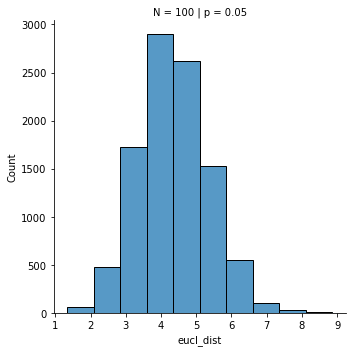

In [860]:
sns.displot(data=res[(res.N==100) &(res.p==0.05)], bins=10, kind="hist", x="eucl_dist", row="N", col="p")

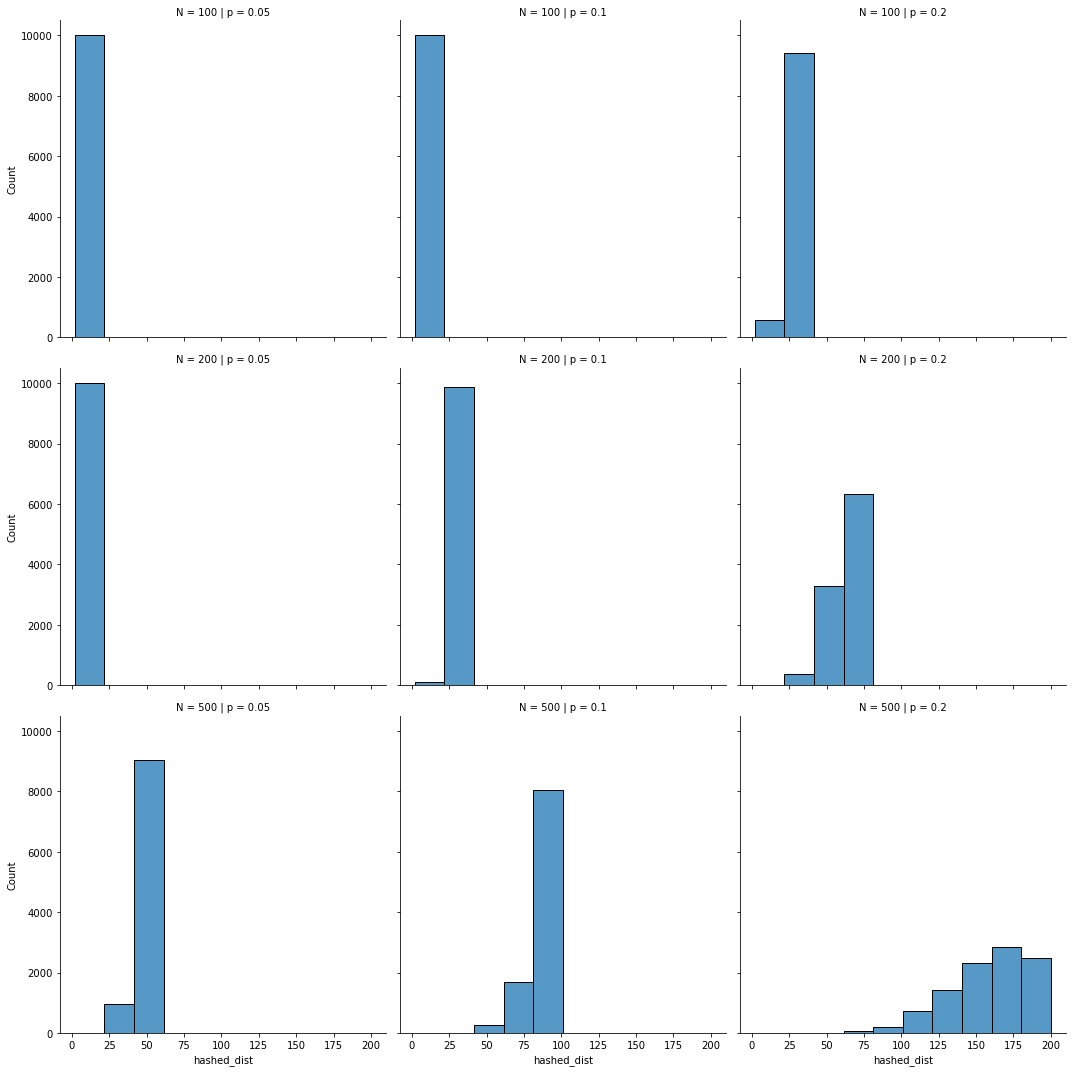

In [861]:
sns.displot(data=res, bins=10, kind="hist", x="hashed_dist", row="N", col="p")

In [629]:
avg = res.groupby(['hashed_dist', 'N', 'p'], as_index=False).mean()

std = res.groupby(['hashed_dist', 'N', 'p'], as_index=False).std()

In [852]:
N100_p005 = res[(res.N==100)&(res.p==0.05)]

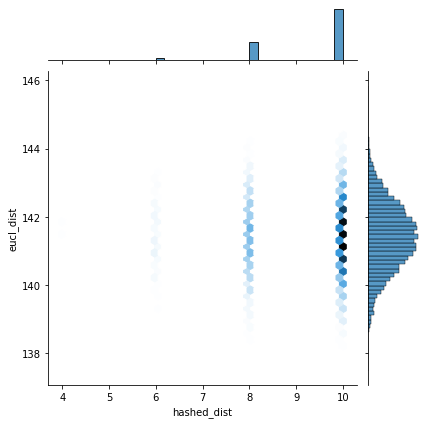

In [853]:
sns.jointplot(data=N100_p005, x="hashed_dist", y="eucl_dist", kind="hex")

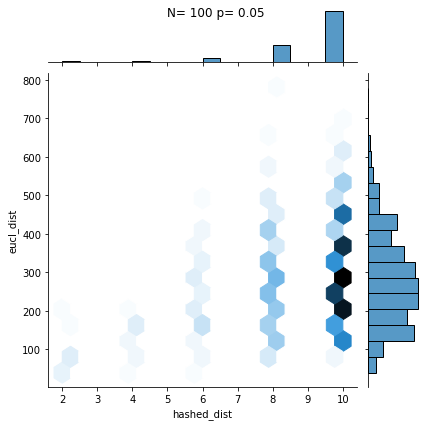

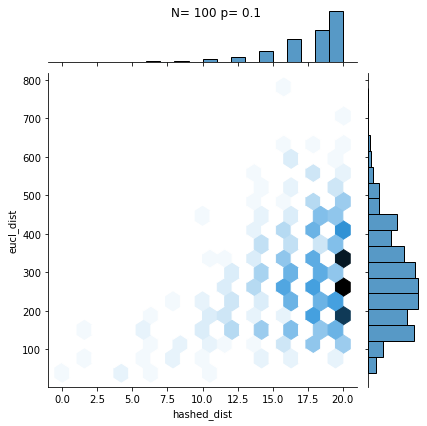

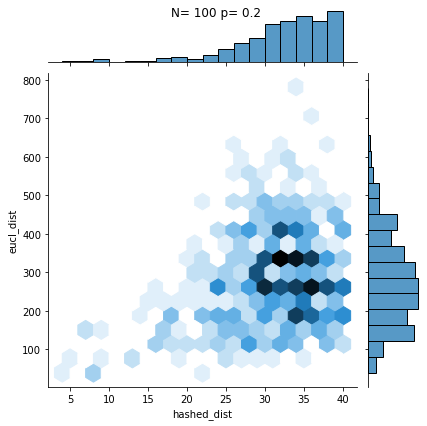

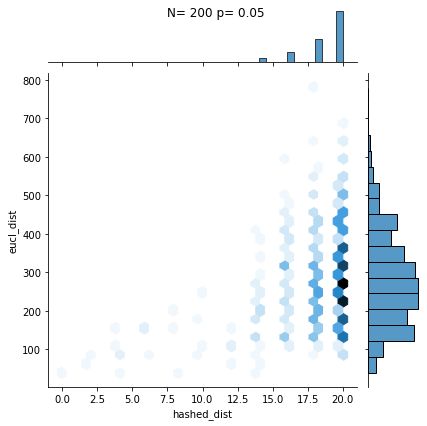

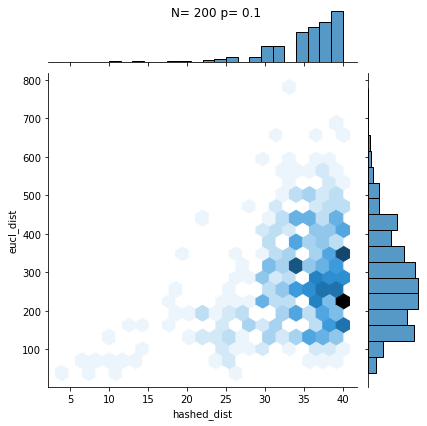

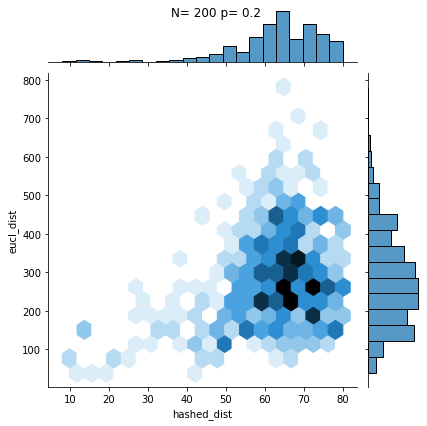

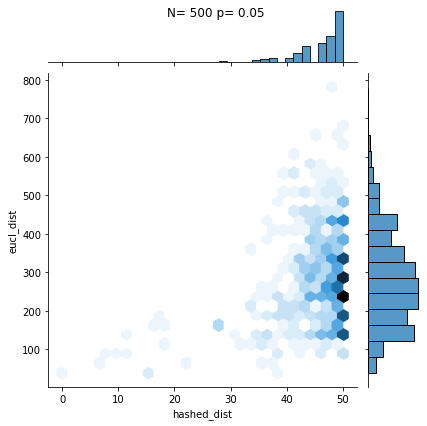

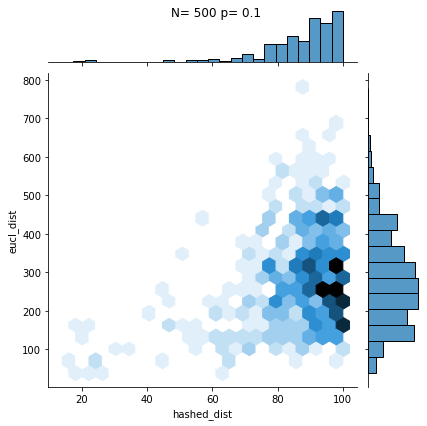

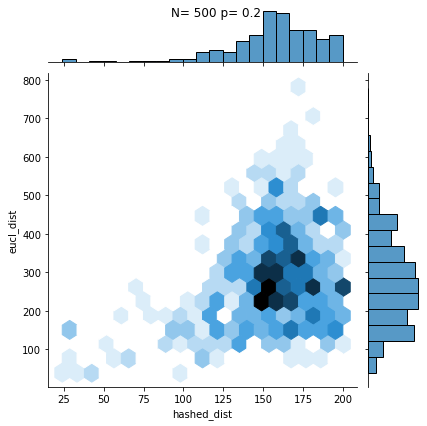

In [822]:
for N_ in [100,200,500]:
    for p_ in [0.05, 0.1, 0.2]:
        df = res[(res.N==N_)&(res.p==p_)]
        g = sns.jointplot(data=df, x="hashed_dist", y="eucl_dist", kind="hex")
        g.fig.suptitle('N= '+ str(N_)+ " p= "+ str(p_))
        g


/Users/nika/miniconda/envs/am/lib/python3.9/site-packages/seaborn/categorical.py:3808: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


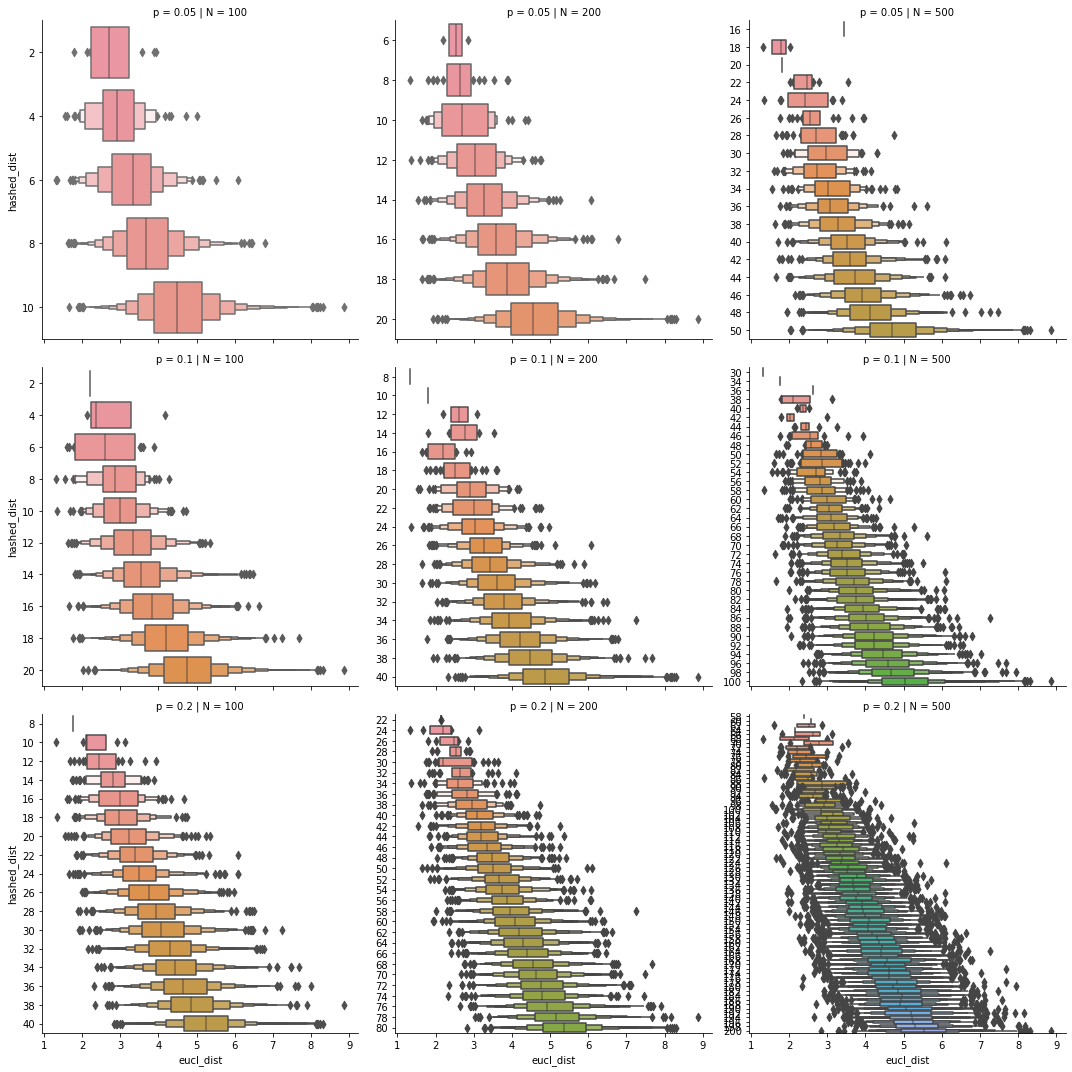

In [862]:
fig = sns.catplot(data=res, y="hashed_dist",x="eucl_dist", col="N", row="p", kind="boxen", sharey=False, orient="h")
fig

In [868]:
mean_df = res.groupby(by=["N","p","hashed_dist"], as_index=False).mean()
std_df = res.groupby(by=["N","p","hashed_dist"], as_index=False).std()

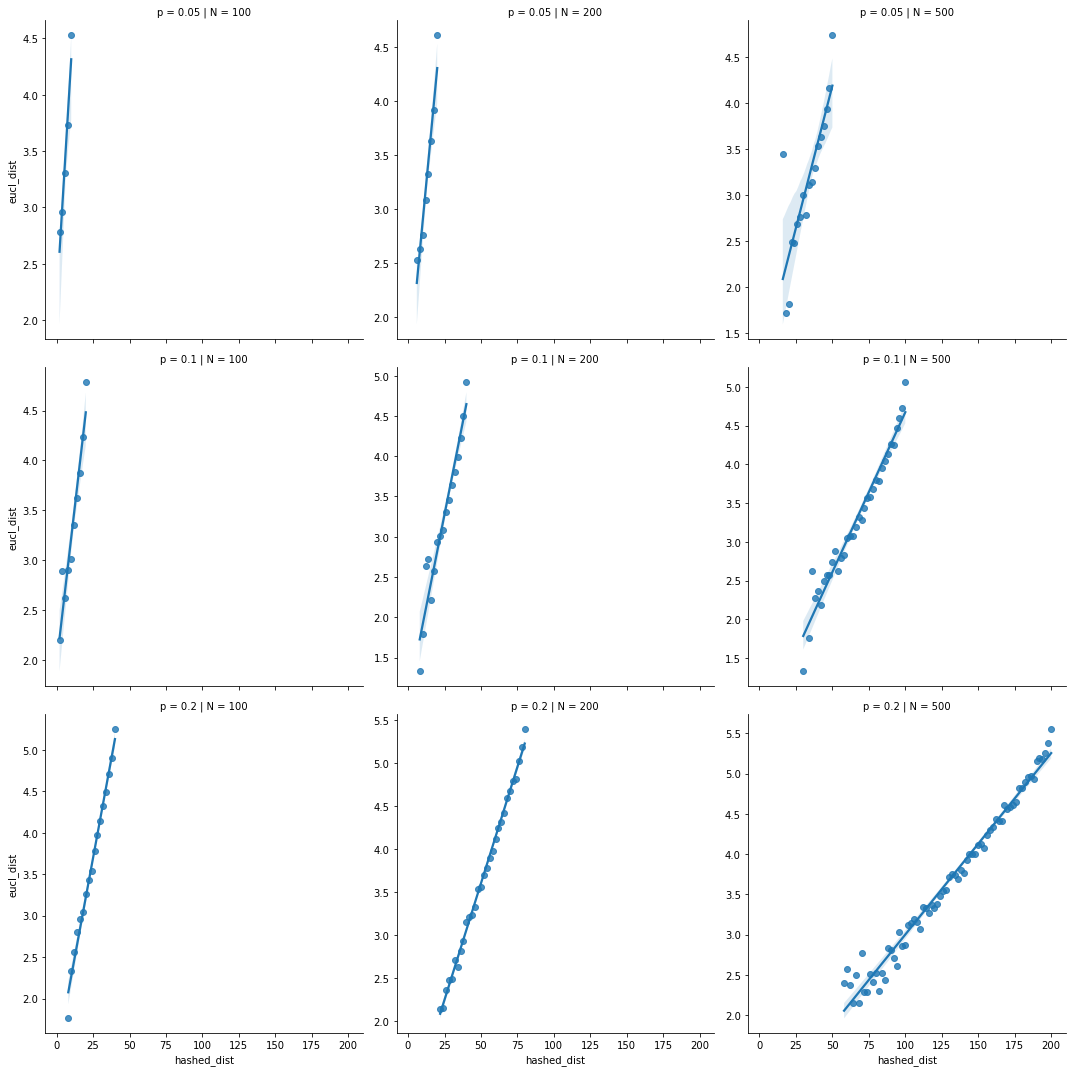

In [867]:
fig = sns.lmplot(data=mean_df, x="hashed_dist",y="eucl_dist", col="N", row="p", facet_kws={'sharey':False})


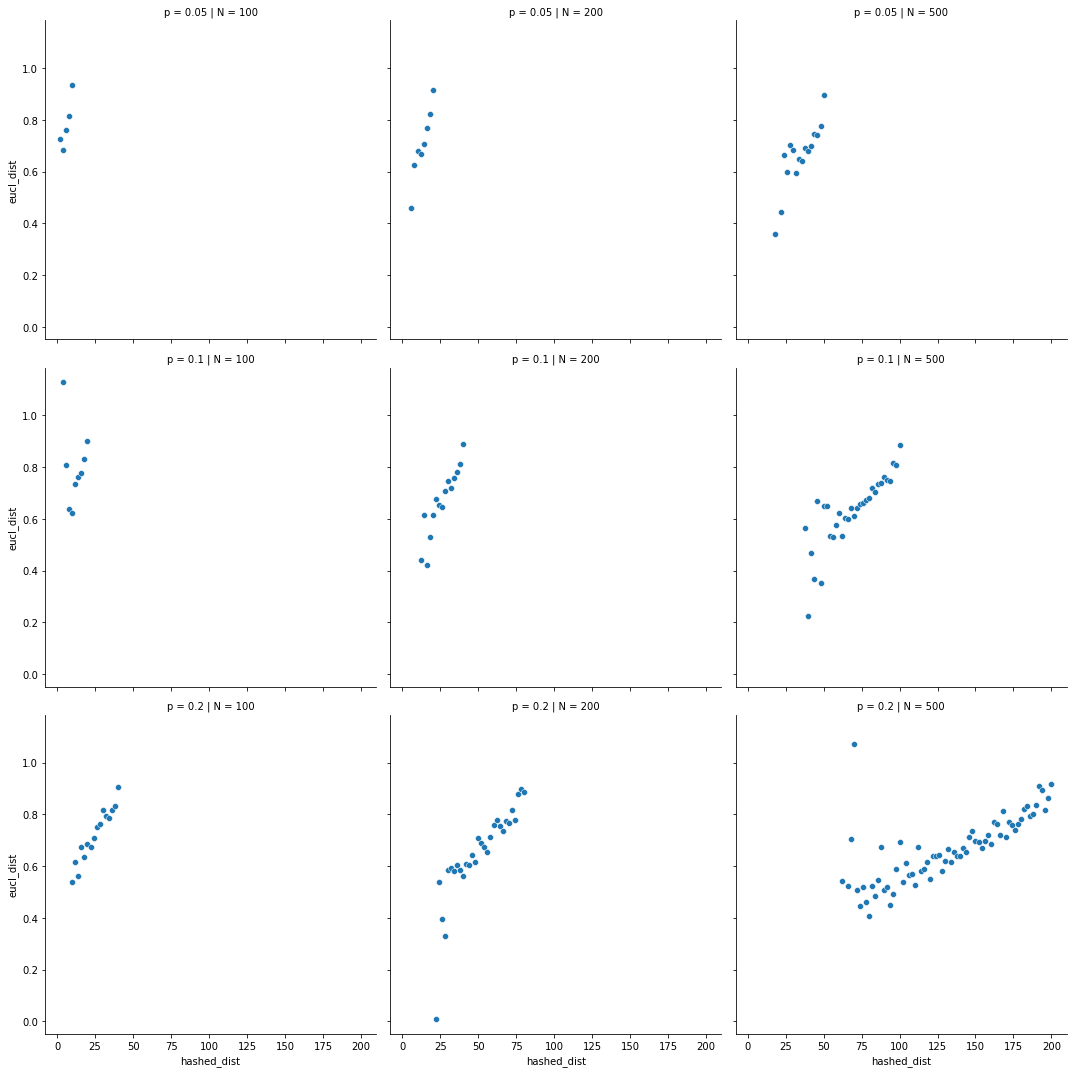

In [872]:
fig = sns.relplot(data=std_df, x="hashed_dist",y="eucl_dist", col="N", row="p")


In [ ]:
# d = 10
# chaque hash associe a une dist euclid, linear model, for each N&p

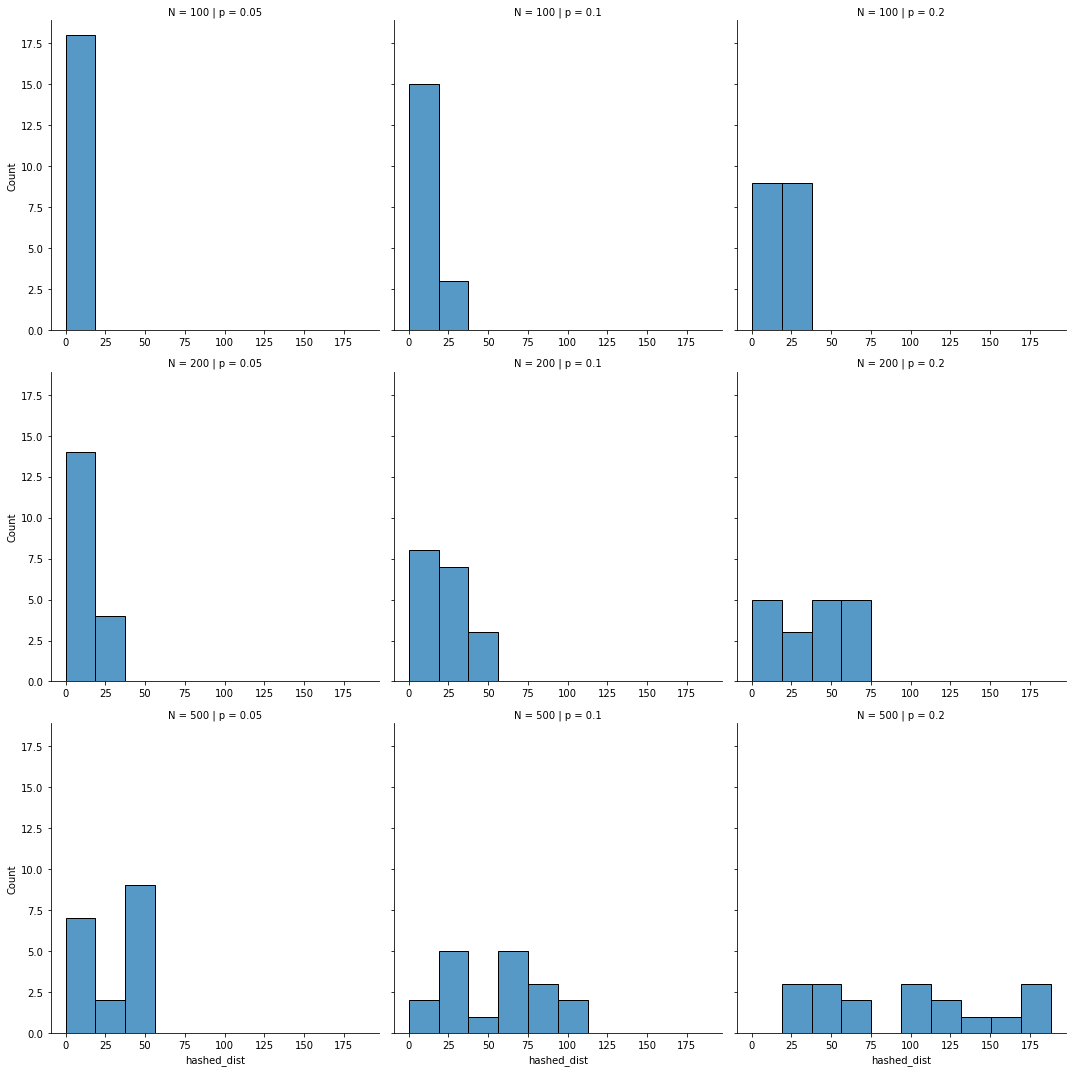

In [836]:
eucl_100 = res[res.eucl_dist < 100]

sns.displot(data=eucl_100, bins=10, kind="hist", x="hashed_dist", row="N", col="p", facet_kws={'sharex':False})

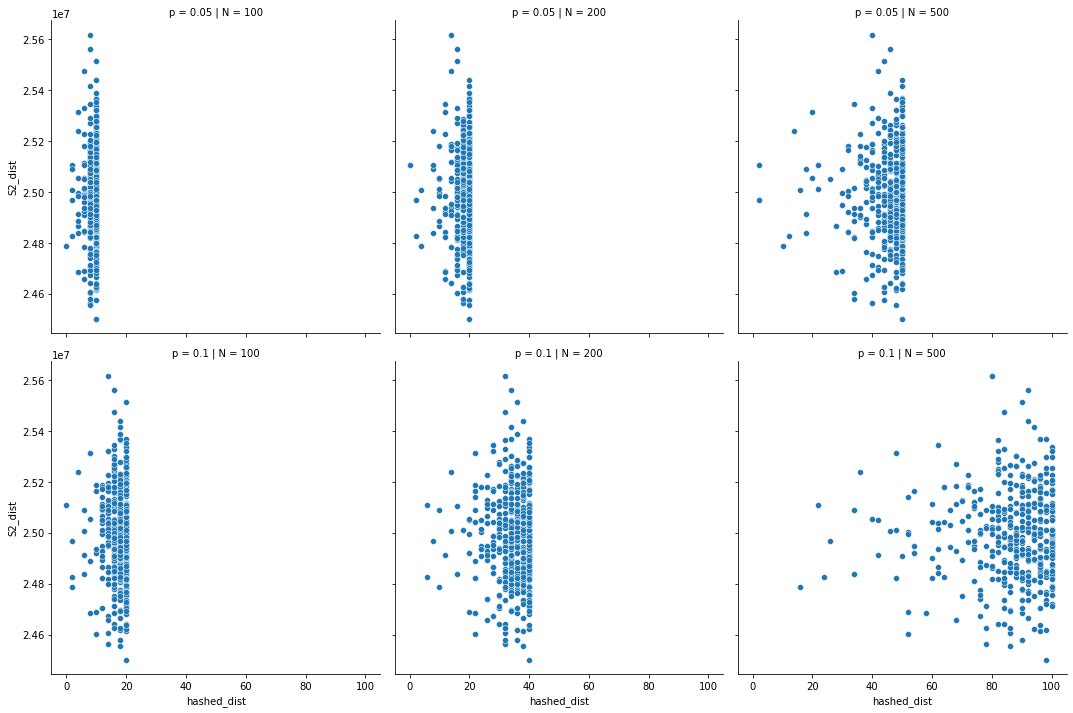

In [805]:
g = sns.relplot(x="hashed_dist", y="S2_dist", col="N", row="p", data=res_S2, kind="scatter")
g

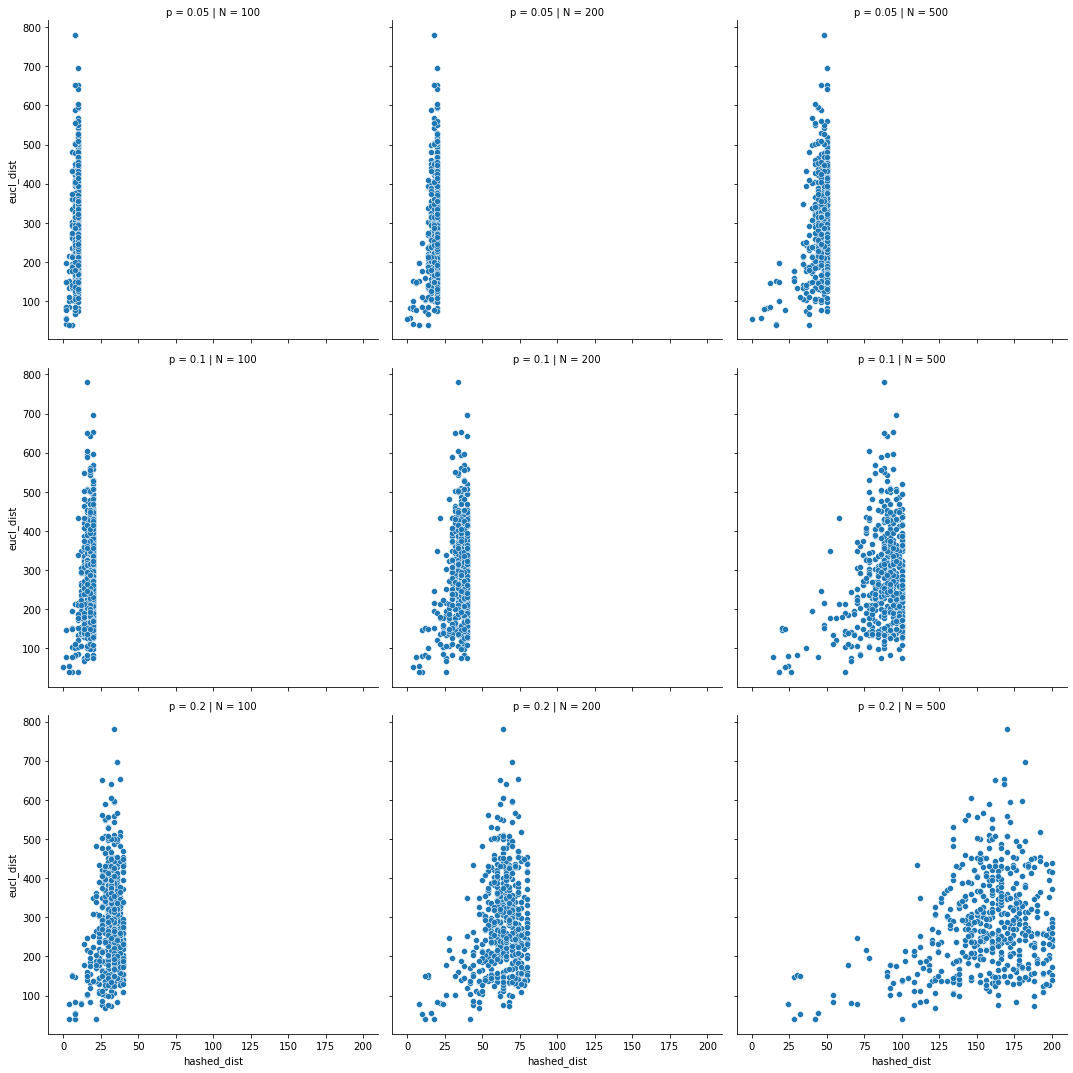

In [803]:
g = sns.relplot(x="hashed_dist", y="eucl_dist", col="N", row="p", data=res, kind="scatter")
g

## References

[1] Dasgupta, S., Stevens, C. F., & Navlakha, S. (2017). A neural algorithm for a fundamental computing problem. Science, 358(6364), 793-796. 

[2] Yagnik, J., Strelow, D., Ross, D. A., & Lin, R. S. (2011, November). The power of comparative reasoning. In 2011 International Conference on Computer Vision (pp. 2431-2438). IEEE.

In [ ]:
# Fit linear filter on the curves in the graph
# predict euclidian distance given a hashed_dist
# given N, p, use the predicted eucl dist for estimating the capacity

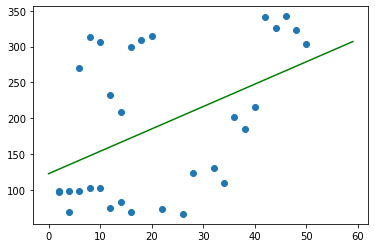

In [801]:
plt.scatter(x=avg_df.hashed_dist, y=avg_df.eucl_dist)

linear_model=np.polyfit(avg_df.hashed_dist,avg_df.eucl_dist,1)
linear_model_fn=np.poly1d(linear_model)
x_s=np.arange(0,60)
plt.plot(x_s,linear_model_fn(x_s),color="green")

In [791]:
import scipy as sp
import scipy.signal as sg
h = sg.get_window('hann', 1)
fil = sg.convolve(avg_df.eucl_dist, h / h.sum())

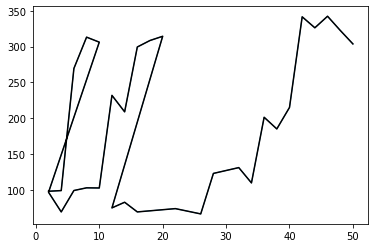

In [792]:
plt.plot(avg_df.hashed_dist,avg_df.eucl_dist, lw=1)
plt.plot(avg_df.hashed_dist,fil[:len(avg_df.eucl_dist)], c='k')

In [741]:
avg_df = res.groupby(by=["N","p","hashed_dist"]).mean()

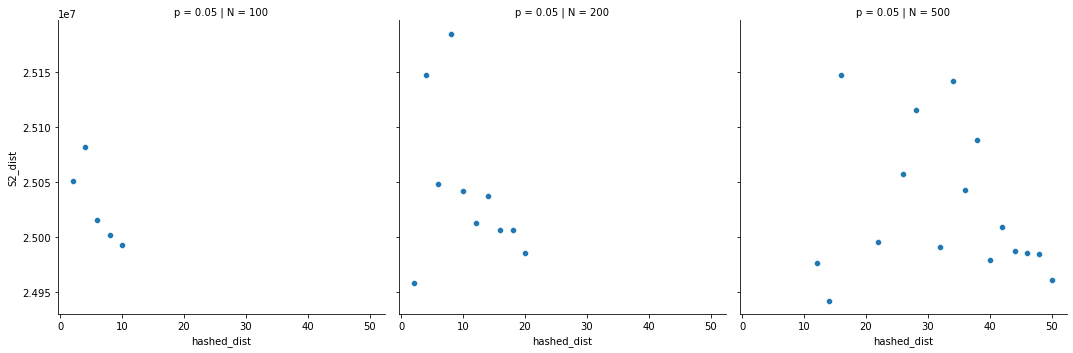

In [742]:
g = sns.relplot(x="hashed_dist", y="S2_dist", col="N", row="p", data=avg_df, kind="scatter")
g

In [753]:
avg_df.reset_index(inplace=True)

In [754]:
avg_df

,N,p,hashed_dist,i,j,eucl_dist,S2_dist
0,100,0.05,2,235.000000,127.0,98.468365,2.505116e+07
1,100,0.05,4,211.166667,127.0,99.398225,2.508171e+07
2,100,0.05,6,261.787879,127.0,269.564793,2.501580e+07
3,100,0.05,8,252.376238,127.0,313.161307,2.500227e+07
4,100,0.05,10,248.429379,127.0,306.183036,2.499245e+07
5,200,0.05,2,364.500000,127.0,97.062353,2.495798e+07
6,200,0.05,4,168.000000,127.0,69.681326,2.514780e+07
7,200,0.05,6,230.000000,127.0,99.501610,2.504848e+07
8,200,0.05,8,235.000000,127.0,103.241207,2.518511e+07
9,200,0.05,10,170.000000,127.0,103.020303,2.504161e+07
